In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn

In [2]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/RNN_MPC_data.csv')

In [3]:
display(data_frame.head(5))

,x1,x2,u1,u2
0,1.000000,300.000000,3.419154,61.201253
1,1.198907,310.266894,0.500801,-54.907623
2,1.132610,301.652314,1.527291,-113.239288
3,1.146201,283.779092,1.803821,-42.899801
4,1.173853,278.641640,3.277372,10.782427


In [4]:
# Defining a batch size based on the data
batch_size = 101

# Split the dataset into different batches
batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))

# Shifting batch number 5 to the end to be used as a test data
batch_data.append(batch_data.pop(5))

# Combining all the batches to form a single dataset
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))

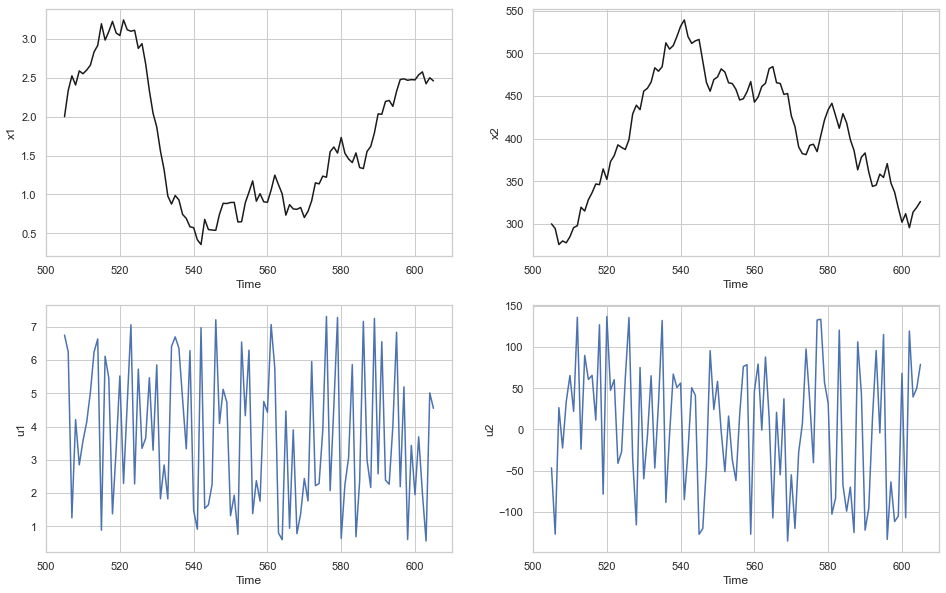

In [5]:
# Plotting the test data batch
fig = plt.figure(figsize=(16,10))

batch_no = 15

plt.subplot(2, 2, 1)
plt.plot(batch_data[batch_no-1]['x1'],'k')
plt.xlabel('Time')
plt.ylabel('x1')

plt.subplot(2, 2, 2)
plt.plot(batch_data[batch_no-1]['x2'],'k')
plt.xlabel('Time')
plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.plot(batch_data[batch_no-1]['u1'],'b')
plt.xlabel('Time')
plt.ylabel('u1')

plt.subplot(2, 2, 4)
plt.plot(batch_data[batch_no-1]['u2'],'b')
plt.xlabel('Time')
plt.ylabel('u2')

plt.show()

In [6]:
# Define a test size
test_size = batch_size

y = df.values.astype(float)

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

# Convert train set into a torch tensor
train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])

In [7]:
# Creating a function to generate the input data for the lstm 
def input_data(seq,ws):
    
    inp_data = []
    
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+101]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:2]

            inp_data.append((window,label))
        
    return inp_data

In [8]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

In [9]:
# Defining the LSTM model with two hidden layers
class LSTMmodel(nn.Module):
    
    def __init__(self,input_size,hidden_size_1,hidden_size_2,out_size):
        
        super().__init__()
        
        self.hidden_size_1 = hidden_size_1
        
        self.hidden_size_2 = hidden_size_2
        
        self.input_size = input_size
        
        self.lstm_1 = nn.LSTM(input_size,hidden_size_1)
        
        self.lstm_2 = nn.LSTM(hidden_size_1,hidden_size_2)
        
        self.linear = nn.Linear(hidden_size_2,out_size)
        
        self.hidden_1 = (torch.zeros(1,1,hidden_size_1), torch.zeros(1,1,hidden_size_1))
        
        self.hidden_2 = (torch.zeros(1,1,hidden_size_2), torch.zeros(1,1,hidden_size_2))
        
    def forward(self,seq):
        
        lstm_out_1 , self.hidden_1 = self.lstm_1(seq.view(-1,1,self.input_size),self.hidden_1)
        
        lstm_out_2 , self.hidden_2 = self.lstm_2(lstm_out_1,self.hidden_2)
        
        pred = self.linear(lstm_out_2.view(len(seq),-1))
        
        return pred

In [10]:
# Creating a model instance, loss function and the optimizer
model = LSTMmodel(input_size=4,hidden_size_1=50,hidden_size_2=50,out_size=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [11]:
display(model)

LSTMmodel(
  (lstm_1): LSTM(4, 50)
  (lstm_2): LSTM(50, 50)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [12]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   800
 10000
   200
   200
 10000
 10000
   200
   200
   100
     2
______
 31702


In [14]:
# Set the number of epochs

epochs = 100

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,1400,100):
    
        for seq,label in train_data[bat:bat+100]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            
            # initialize the hidden states

            model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                            torch.zeros(1,1,model.hidden_size_1))

            model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                            torch.zeros(1,1,model.hidden_size_2))
            
            # Make predictions on the current sequence

            y_pred = model(seq)
            
            # Compute the loss

            loss = criterion(y_pred, label)
            
            # Perform back propogation and gradient descent

            loss.backward()

            optimizer.step()

    if epoch%10 == 0:

        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')

Epoch: 0 Loss: 26521.81445312
Epoch: 10 Loss: 1185.89172363
Epoch: 20 Loss: 57.46641541
Epoch: 30 Loss: 61.40365219
Epoch: 40 Loss: 132.39303589
Epoch: 50 Loss: 101.70886993
Epoch: 60 Loss: 146.00573730
Epoch: 70 Loss: 112.68241882
Epoch: 80 Loss: 69.38909149
Epoch: 90 Loss: 83.69350433


In [15]:
future = 100

# Set the model to evaluation mode

model.eval()

preds = [test_set[0,:2].reshape(-1,2)]

for i in range(future):
    
    seq = test_set[i].reshape(-1,4)
    
    # Informing PyTorch that I am no longer interested in the gradients
    
    with torch.no_grad():
        
        # Initialize the hidden states
        
        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        
        preds.append(model(seq))

In [16]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,2)
true_values = np.array(test_set[:,:2])

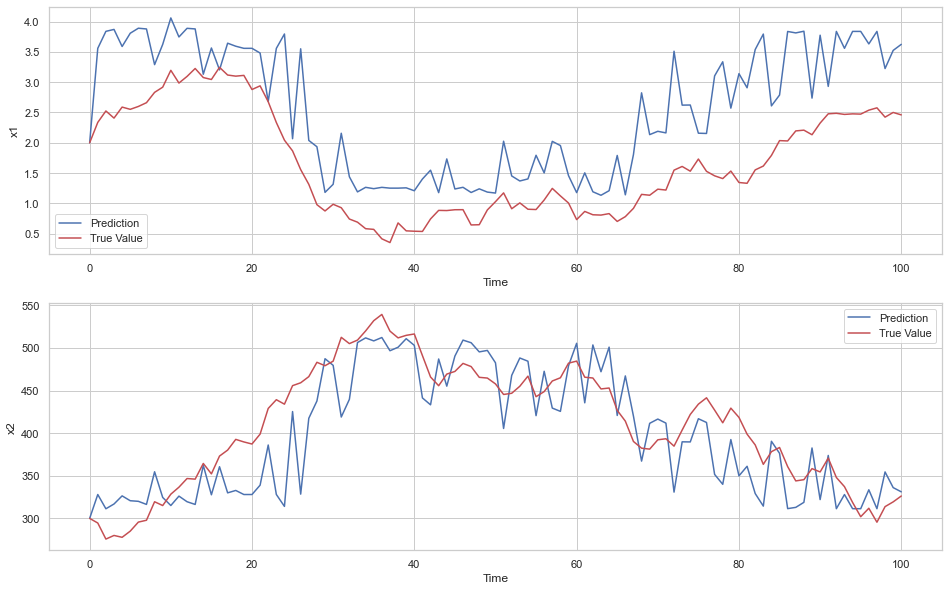

In [17]:
fig = plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

plt.subplot(2, 1, 2)
plt.plot(predictions[:,1],'b',label='Prediction')
plt.plot(true_values[:,1],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x2');

In [18]:
RMSE = np.sqrt(np.sum(np.square((predictions - true_values)))/202)
display(RMSE)

28.402413481677193